# MPI for Sonar simulation

## Imports

In [1]:
import ipyparallel as ipp
c = ipp.Client(profile='mpi')

In [2]:
%%px --no-stream --group-outputs=engine
%matplotlib inline
from mpi4py import MPI
import sys
import os
import tqdm

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable


sys.path.insert(0, os.path.abspath("/home/hajta2/study/sonar-FWI/cli/"))
from simulation.sonar import Sonar
from simulation.utils import (
    FlatBottom,
    CircleBottom,
    EllipsisBottom,
    run_beam,
    positions_line,
    positions_half_circle,
    calculate_coordinates_from_pos,
)
from simulation.plotting import plot_velocity, plot_attenuation
from simulation.sources import GaborSource

from examples.seismic import WaveletSource, Receiver
from devito import configuration

plt.rcParams["figure.figsize"] = (10, 10)
configuration['language'] = 'openmp'
configuration['mpi'] = True

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

## Initialization

In [3]:
%%px --no-stream --group-outputs=engine

domain_size = (60, 30)
radius = 28
v_env = 1.5
ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance
f0 = 50
space_order = 8
spatial_dist = round(v_env / f0 / 3, 3)
dt = spatial_dist / 20

In [4]:
%%px --no-stream --group-outputs=engine

sonar = Sonar(
    domain_size,
    f0,
    v_env,
    EllipsisBottom(True),
    space_order=space_order,
    dt=dt,
    spatial_dist=spatial_dist,
)
sonar.set_source()
sonar.finalize()

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
51it [00:04, 11.64it/s]
Operator `initdamp` ran in 0.02 s
[stderr:1] 
51it [00:04, 11.59it/s]
Operator `initdamp` ran in 0.02 s


[output:0]

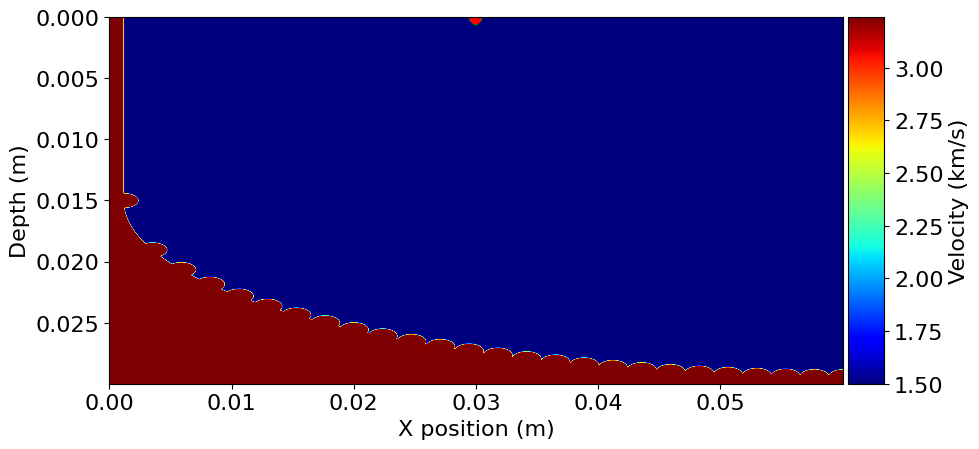

[output:1]

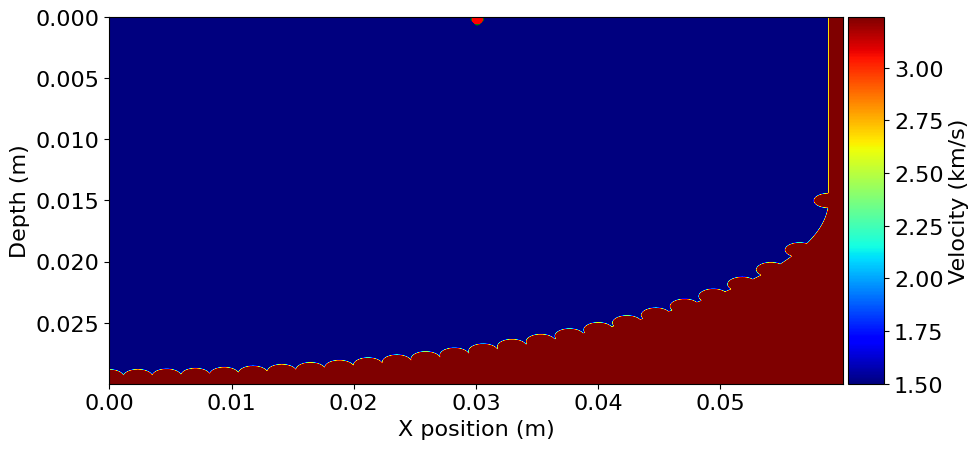

In [5]:
%%px

plot_velocity(
    sonar.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data
)

[output:1]

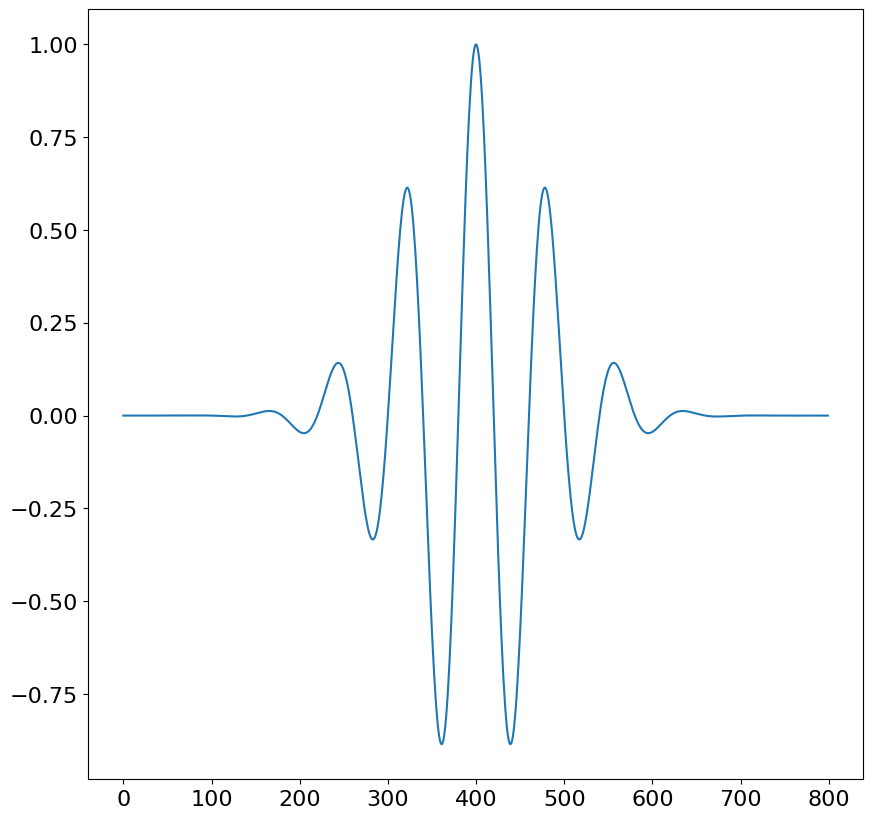

[output:0]

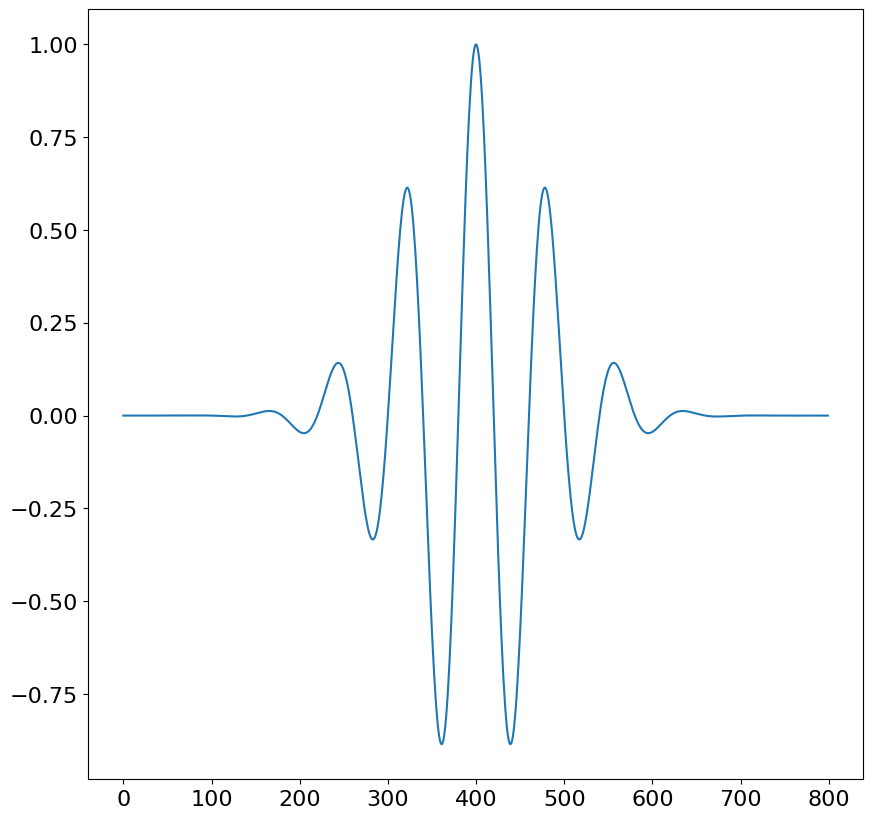

In [6]:
%%px

ideal_signal = sonar.src.signal_packet
plt.plot(ideal_signal)
plt.show()

In [7]:
%%px

# run the simulation and collect the rec data on the rank 0
recording = run_beam(
    sonar.src,
    sonar.rec,
    sonar.op,
    sonar.u,
    sonar.source_distance,
    sonar.time_range,
    sonar.model.critical_dt,
    45,
    v_env,
)

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:1] Operator `Kernel` ran in 5229.98 s
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


[stderr:0] Operator `Kernel` ran in 5229.98 s
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


[stdout:1] Simulation took 5232.74413228035 seconds


[1:execute]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[6], line 16
      2 recording = run_beam(
      3     sonar.src,
      4     sonar.rec,
   (...)
     11     v_env,
     12 )
     14 all_recording = MPI.COMM_WORLD.gather(recording, root=0)
---> 16 if rank == 0:
     17     all_recording = np.concatenate(all_recording, axis=0)

NameError: name 'rank' is not defined


[stdout:0] Simulation took 5232.74409532547 seconds


[0:execute]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[6], line 16
      2 recording = run_beam(
      3     sonar.src,
      4     sonar.rec,
   (...)
     11     v_env,
     12 )
     14 all_recording = MPI.COMM_WORLD.gather(recording, root=0)
---> 16 if rank == 0:
     17     all_recording = np.concatenate(all_recording, axis=0)

NameError: name 'rank' is not defined


AlreadyDisplayedError: 2 errors

In [11]:
%%px
rank = MPI.COMM_WORLD.Get_rank()

all_recording = MPI.COMM_WORLD.gather(recording, root=0)

if rank == 0:
    all_recording = np.concatenate(all_recording, axis=1)
    print(all_recording.shape)

[stderr:0] Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


[stderr:1] Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


[stdout:0] (123139, 128)


[output:0]

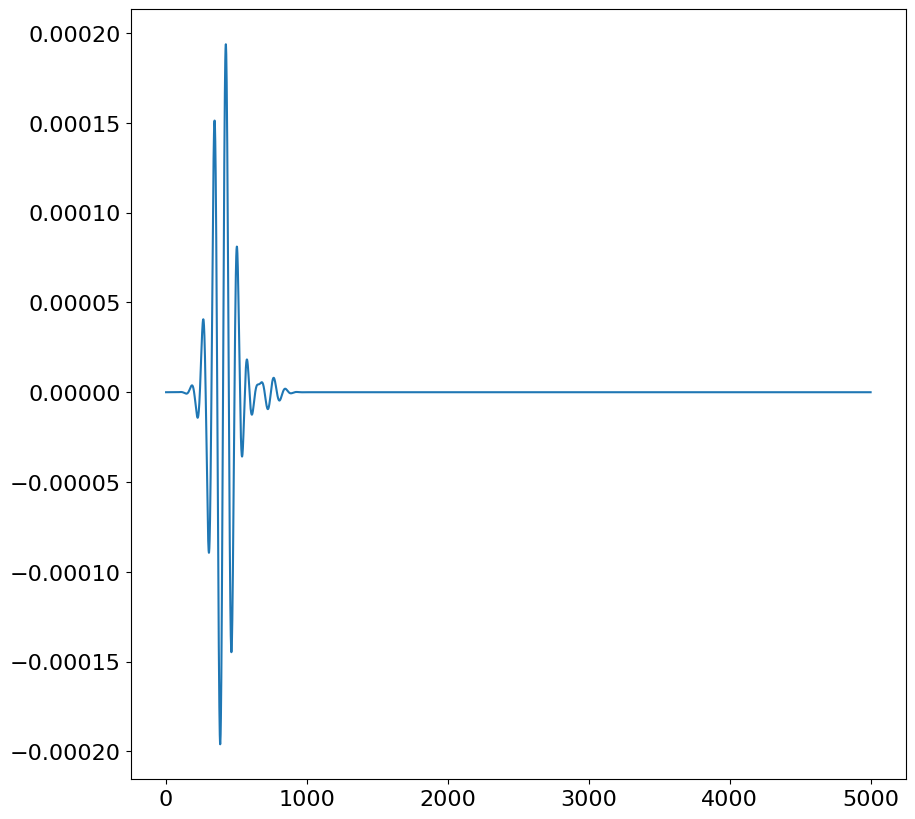

In [12]:
%%px

if rank == 0:
    plt.plot(all_recording[:5000, 64])
    start_time = np.argmax(all_recording[:5000, 64])

[output:0]

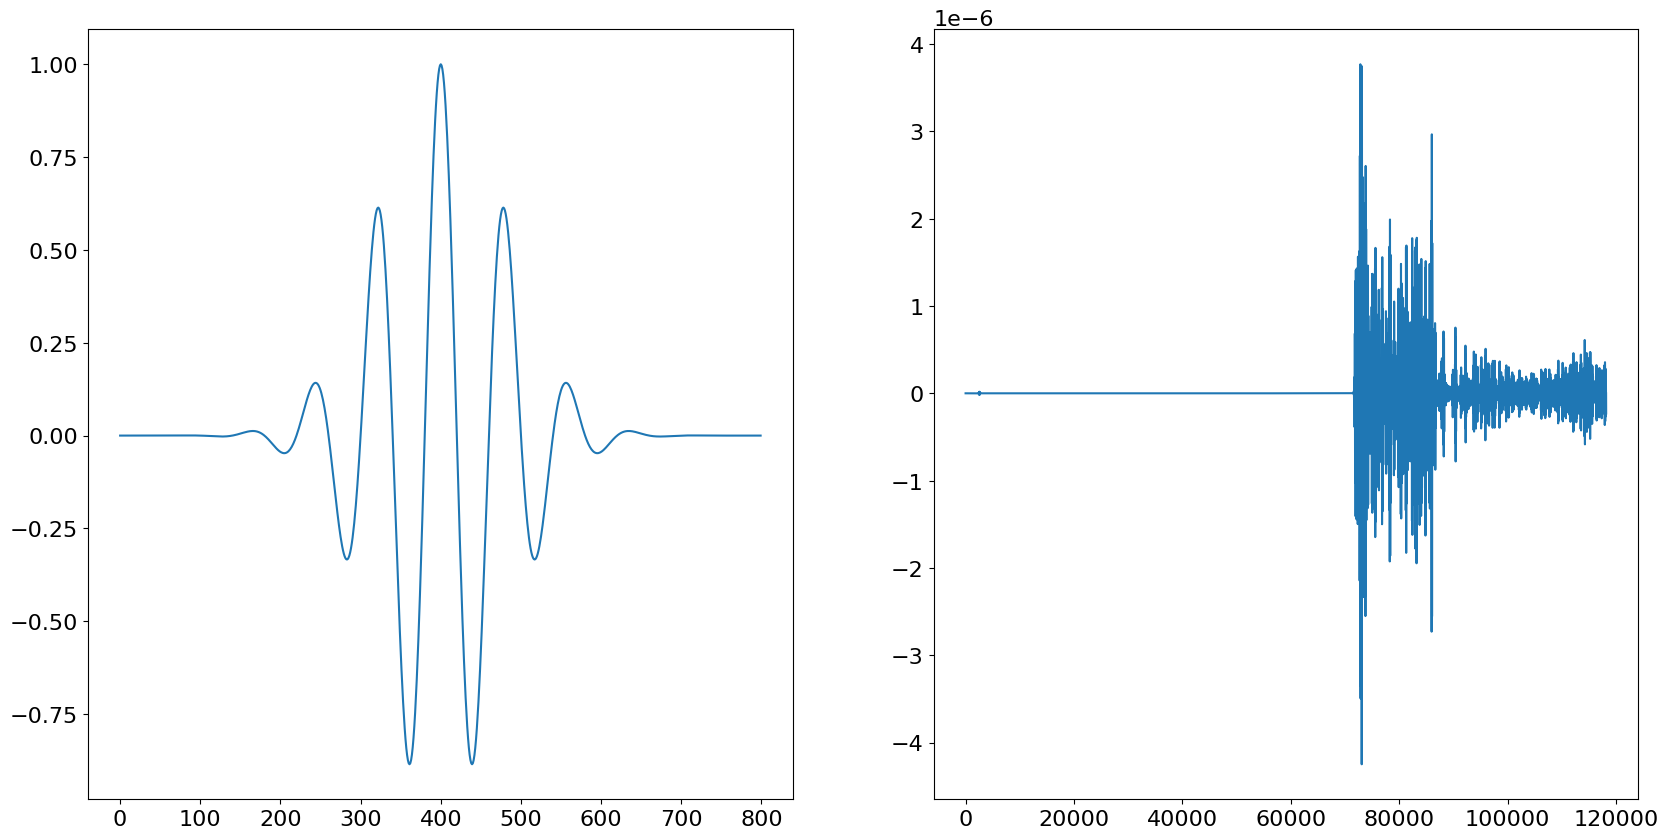

In [14]:
%%px

if rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].plot(ideal_signal)
    ax[1].plot(all_recording[5000:, 64])

[output:0]

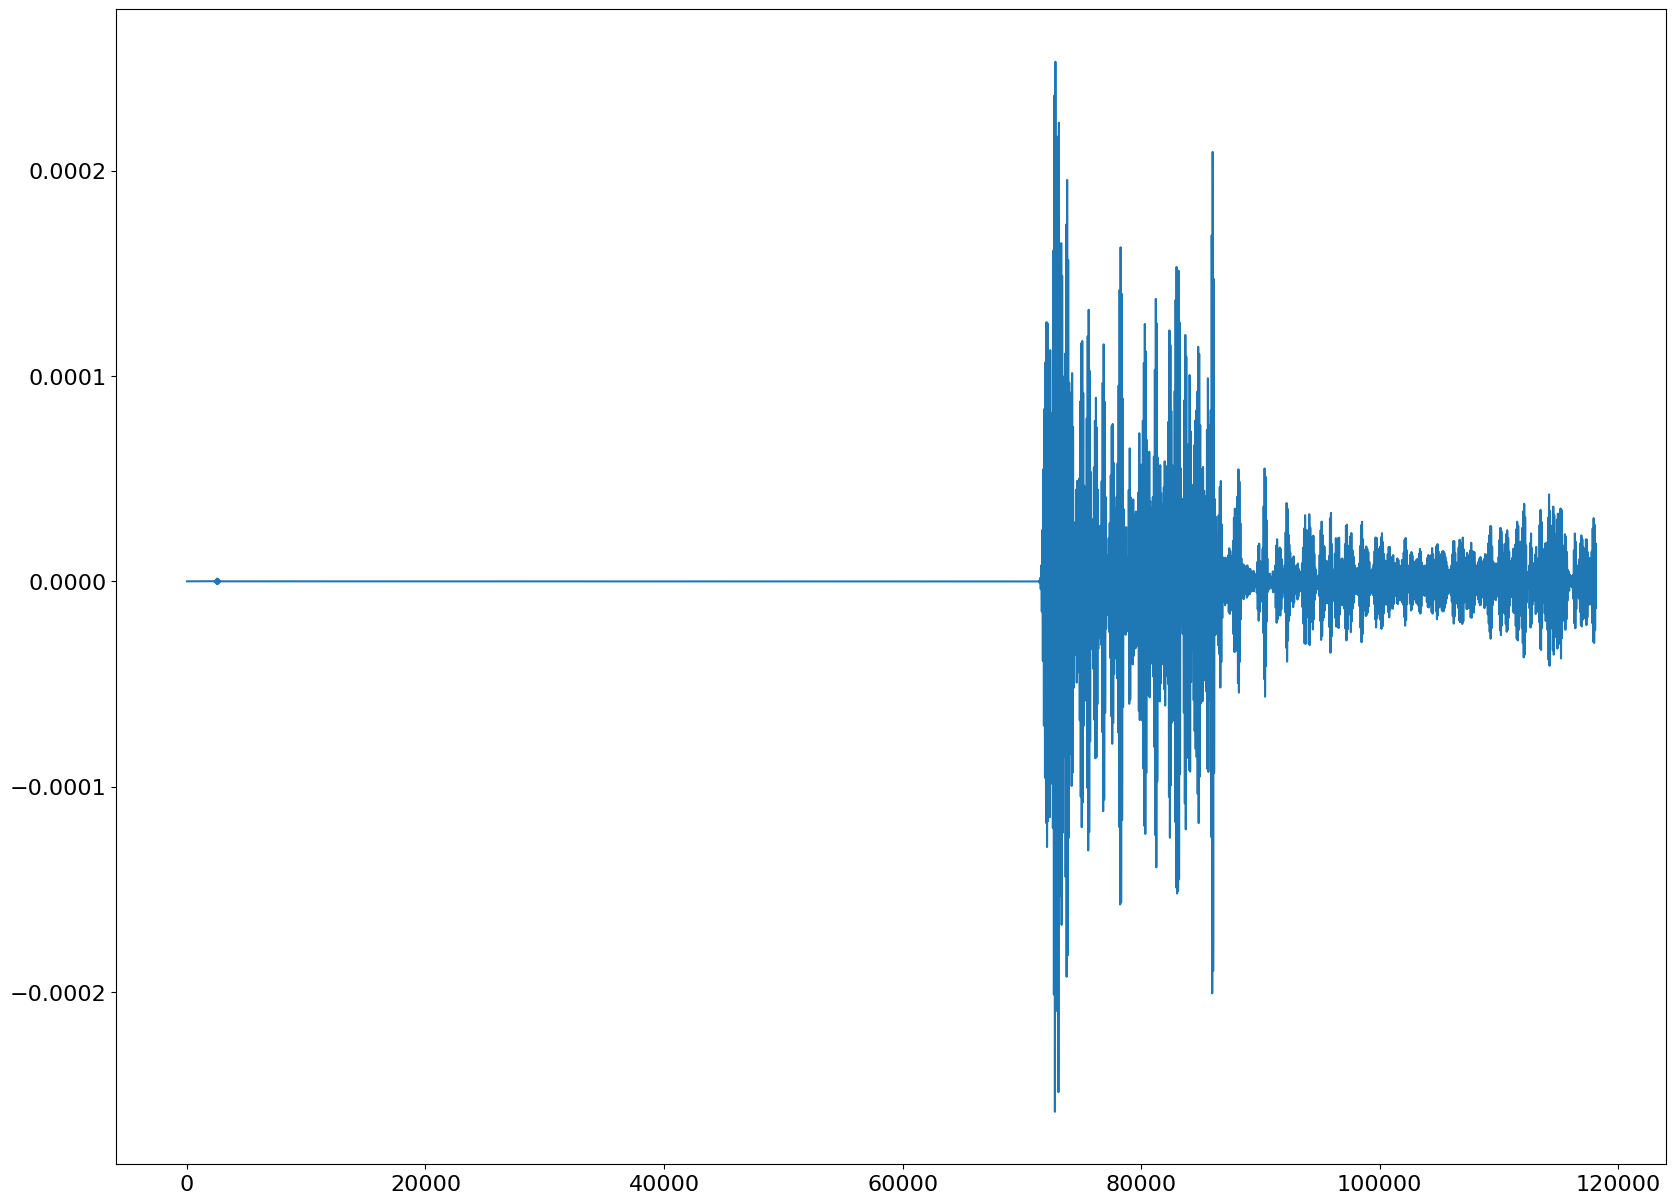

[stdout:0] 72812


In [16]:
%%px

if rank == 0:
    correlate = np.correlate(all_recording[5000:, 64], ideal_signal, mode="same")
    plt.figure(figsize=(20, 15))
    plt.plot(correlate)
    plt.show()
    print(np.argmax(correlate))

[output:0]

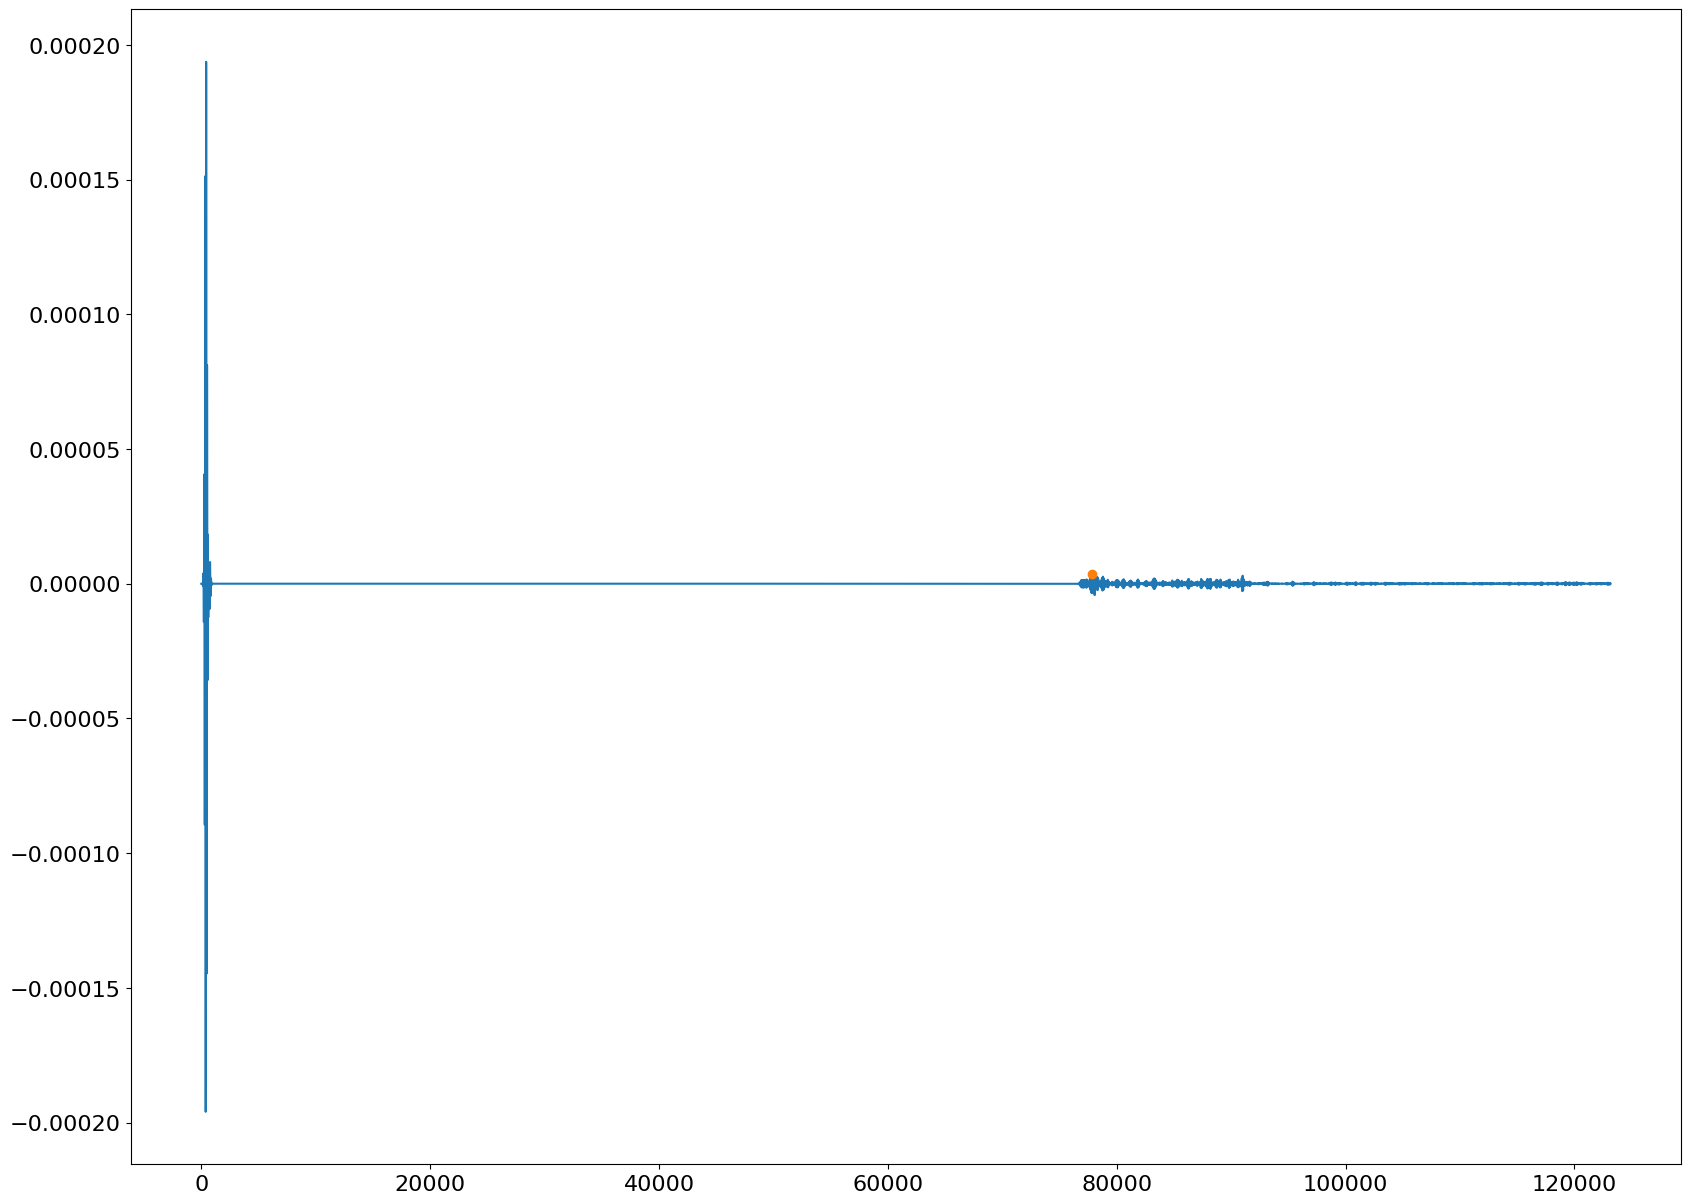

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

Received Keyboard Interrupt. Sending signal SIGINT to engines...


In [18]:
%%px

if rank == 0:
    peak = 5000 + correlate.argmax()
    ## change the figure size
    plt.figure(figsize=(20, 15))
    plt.plot(all_recording[:, 64])
    plt.plot(peak, all_recording[peak, 64], "o")
    plt.show()

In [20]:
%%px

if rank == 0:
    distance = (peak - start_time) * dt * v_env / 2
    print(f"Distance: {distance} m")

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

Received Keyboard Interrupt. Sending signal SIGINT to engines...
